In [9]:
from importlib import reload
import tensorflow as tf
import matplotlib.pyplot as plt
import copy
import numpy as np

tf.enable_eager_execution()
tf.random.set_random_seed(0)
from Trajectory.Trajectory import Trajectory, Field
from Hawkes.Hawkes import Hawkes

In [10]:

# make our dummy dataset
labelset = tf.convert_to_tensor([0, 1], dtype=tf.int32)
# construct our dummy hawkes process, with three exponential kernels
nlabels = len(labelset)
kernelparams = [1]
hp = Hawkes(nlabels, kernelparams)
hp.setparams(
tf.random.uniform((nlabels, nlabels, len(kernelparams)),
                                minval=10, maxval=100),
    tf.random.uniform((nlabels,), minval=10, maxval=20))
print(hp.parameters)
hp2 = Hawkes(len(labelset), kernelparams)
eta = 0.1
endtimes = 1


traj = Trajectory(
    {
        "times" : Field(values=[], continuous=True, space=(0, endtimes)),
        "labels" : Field(values=[], continuous=False, space=labelset)
    }, 0.2)


[<tf.Variable 'Variable:0' shape=(2, 2, 1) dtype=float32, numpy=
array([[[27.56924],
        [76.61559]],

       [[53.90216],
        [88.77883]]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([11.751354, 13.179742], dtype=float32)>]


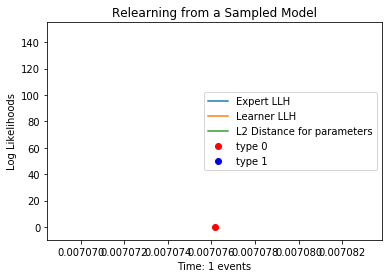

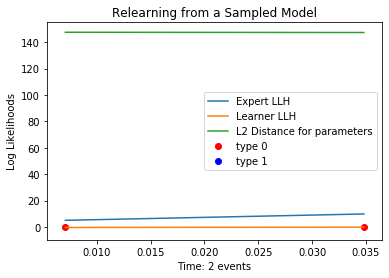

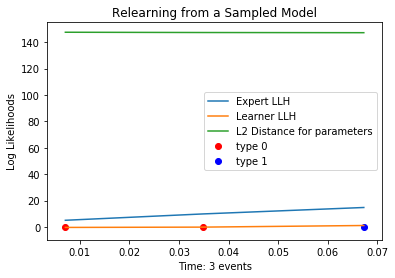

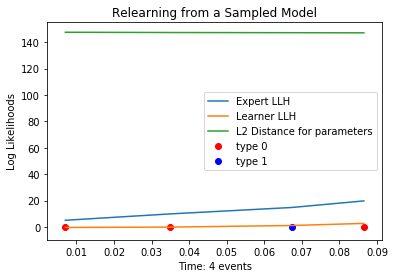

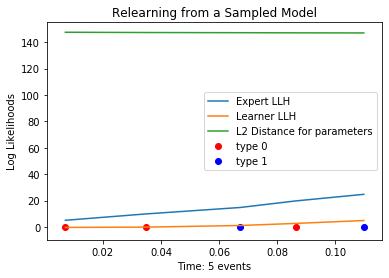

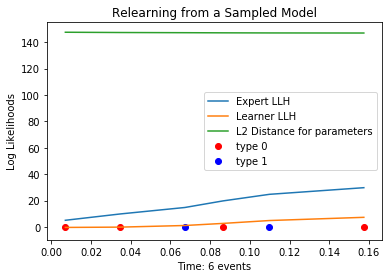

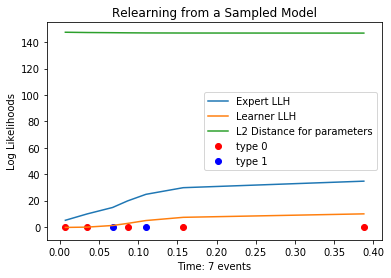

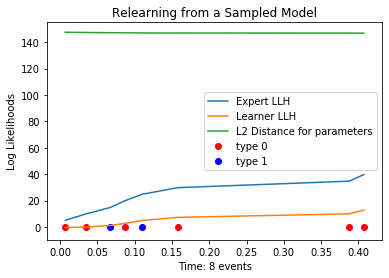

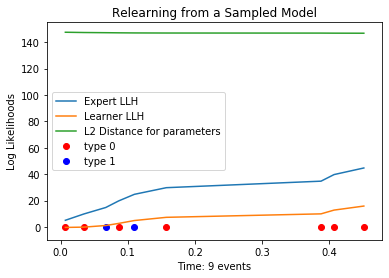

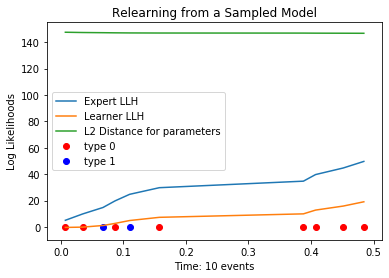

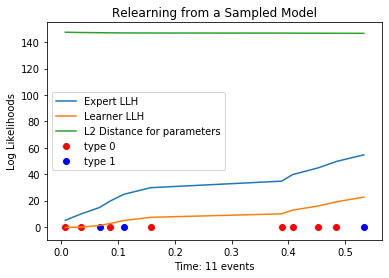

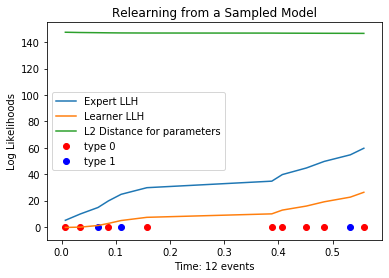

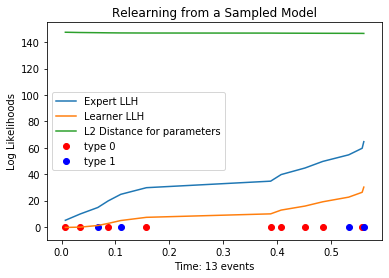

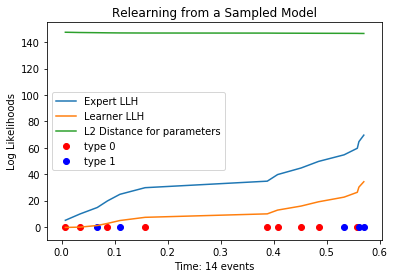

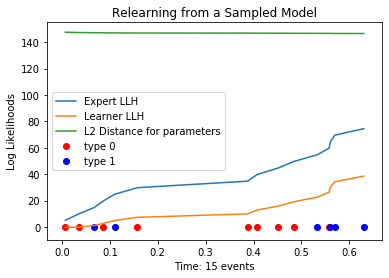

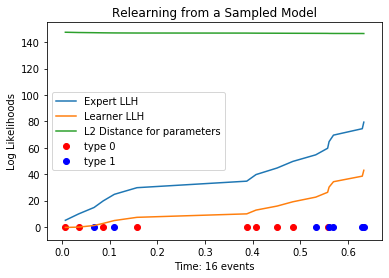

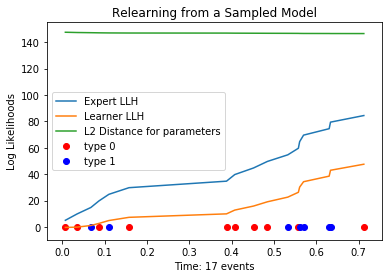

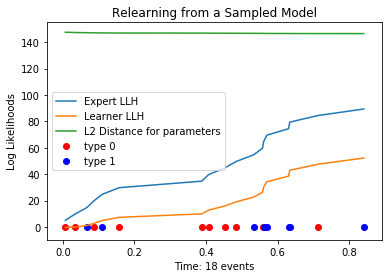

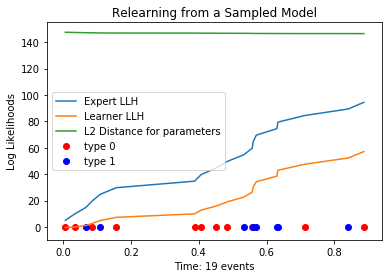

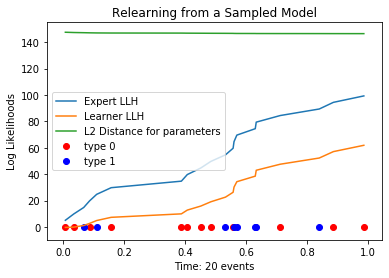

In [13]:
hpllh = 0
hp2llh = 0

hpllhs = []
hp2llhs = []

l0times = []
l1times = []

dists = []
times = []

hp.resetstate()
hp2.resetstate()
for timeslice in hp.sample_next_event():
    time = timeslice.time.numpy()[0]
    if time > endtimes:
        break

    if timeslice.label.numpy() == 0:
        l0times.append(time)
    else:
        l1times.append(time)
    hp2.gradstep(timeslice, eta)
    times.append(timeslice.time.numpy()[0])

    # I want actual LLH
    hpllh -= hp.calcsegnegllh(hp.state, timeslice).numpy()
    hpllhs.append(hpllh)

    wdist = tf.norm(hp.parameters[0] - hp2.parameters[0])
    mdist = tf.norm(hp.parameters[1] - hp2.parameters[1])
    dists.append((wdist + mdist).numpy())

    # I want LLH after taking the gradient step...
    hp2llh -= hp2.calcsegnegllh(hp2.state, timeslice).numpy()
    hp2llhs.append(hp2llh)
    
    plt.plot(times, hpllhs, label="Expert LLH")
    plt.plot(times, hp2llhs, label="Learner LLH")
    plt.plot(times, dists, label="L2 Distance for parameters")

    plt.scatter(l0times, [0 for _ in l0times], color='red', label='type 0')
    plt.scatter(l1times, [0 for _ in l1times], color='blue', label='type 1')
    plt.legend()
    plt.xlabel("Time: {} events".format(len(times)))
    plt.ylabel("Log Likelihoods")
    plt.title("Relearning from a Sampled Model")
    plt.show()
    plt.pause(0.01)
